In [75]:
!pip install -U transformers

### Importing Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.imports import *

### Importing Training and Test Set & EDA

In [77]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [78]:
train_set

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [79]:
len(test_set)

36

In [80]:
test_set.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [81]:
train_set.target.value_counts()

,count
target,
composition,24
motor,22
metal,22
data,22
assembly,21
...,...
switch over,1
switch off valve,1
switch control valve,1


In [82]:
train_set.anchor.value_counts()

,count
anchor,
component composite coating,152
sheet supply roller,150
source voltage,140
perfluoroalkyl group,136
el display,135
...,...
dry coating composition1,2
shannon,2
plug nozzle,2


In [83]:
train_set.context.value_counts()

,count
context,
H01,2186
H04,2177
G01,1812
A61,1477
F16,1091
...,...
B03,47
F17,33
B31,24


In [84]:
train_set['section'] = train_set.context.str[0]
train_set.section.value_counts()

,count
section,
B,8019
H,6195
G,6013
C,5288
A,4094
F,4054
E,1531
D,1279


<Axes: >

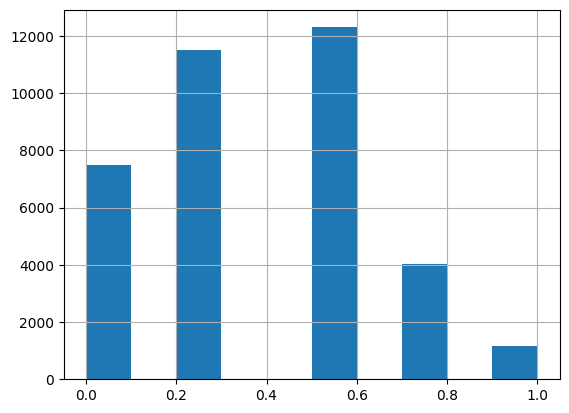

In [85]:
train_set.score.hist()

### Training Our Model

In [86]:
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
import warnings, transformers, logging, torch
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [87]:
model_nm = 'microsoft/deberta-v3-small'

In [88]:
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [89]:
sep = tokz.sep_token
sep

'[SEP]'

In [90]:
train_set['inputs'] = train_set.context + sep + train_set.anchor + sep + train_set.target

### Converting Pandas DataFrames to HuggingFace Datasets

In [91]:
train_ds = Dataset.from_pandas(train_set).rename_column('score', 'label')
test_ds = Dataset.from_pandas(test_set)

In [92]:
def tok_func(x): return tokz(x["inputs"])

In [93]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [94]:
inps = "anchor","target","context"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

### Creating a Validation Set

In [95]:
anchors = train_set.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [96]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]

In [97]:
is_val = np.isin(train_set.anchor, val_anchors)
idxs = np.arange(len(train_set))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

In [98]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})

In [99]:
train_set.iloc[trn_idxs].score.mean(),train_set.iloc[val_idxs].score.mean()

(np.float64(0.3623021530138539), np.float64(0.3613426941641071))

### Initial Model

In [100]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [101]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

In [102]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr)

In [106]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
   eval_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [107]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3843741988.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr)


In [108]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028322,0.797424
2,No log,0.023753,0.811775
3,0.032400,0.025686,0.813093
4,0.032400,0.024513,0.816755


TrainOutput(global_step=856, training_loss=0.024448840417594552, metrics={'train_runtime': 279.3536, 'train_samples_per_second': 391.719, 'train_steps_per_second': 3.064, 'total_flos': 468342161238420.0, 'train_loss': 0.024448840417594552, 'epoch': 4.0})

### Improving Our Model

In [113]:
def get_dds(train_set):
    ds = Dataset.from_pandas(train_set).rename_column('score', 'label')
    tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))
    return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})

In [114]:
def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        eval_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [115]:
sep = " [s] "
train_set['inputs'] = train_set.context + sep + train_set.anchor + sep + train_set.target
dds = get_dds(train_set)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [116]:
get_trainer(dds).train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4272013998.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025921,0.804455
2,No log,0.023581,0.817680
3,0.029300,0.025037,0.815749
4,0.029300,0.024444,0.817357


TrainOutput(global_step=856, training_loss=0.022599000797093472, metrics={'train_runtime': 351.0139, 'train_samples_per_second': 311.748, 'train_steps_per_second': 2.439, 'total_flos': 581591382621300.0, 'train_loss': 0.022599000797093472, 'epoch': 4.0})

In [117]:
train_set['inputs'] = train_set.inputs.str.lower()
dds = get_dds(train_set)
get_trainer(dds).train()

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4272013998.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025420,0.806182
2,No log,0.023600,0.818323
3,0.029700,0.024134,0.819243
4,0.029700,0.023956,0.820017


TrainOutput(global_step=856, training_loss=0.02277011347708301, metrics={'train_runtime': 320.328, 'train_samples_per_second': 341.612, 'train_steps_per_second': 2.672, 'total_flos': 581591382621300.0, 'train_loss': 0.02277011347708301, 'epoch': 4.0})

### Special Tokens

In [118]:
train_set['sectok'] = '[' + train_set.section + ']'
sectoks = list(train_set.sectok.unique())
tokz.add_special_tokens({'additional_special_tokens': sectoks})

8

In [119]:
train_set['inputs'] = train_set.sectok + sep + train_set.context + sep + train_set.anchor.str.lower() + sep + train_set.target
dds = get_dds(train_set)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [120]:
model = get_model()
model.resize_token_embeddings(len(tokz))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(128009, 768, padding_idx=0)

In [121]:
trainer = get_trainer(dds, model=model)
trainer.train()

/tmp/ipython-input-4272013998.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026763,0.802383
2,No log,0.024373,0.815193
3,0.029600,0.024272,0.817105
4,0.029600,0.024184,0.819394


TrainOutput(global_step=856, training_loss=0.022605190210253277, metrics={'train_runtime': 364.6134, 'train_samples_per_second': 300.121, 'train_steps_per_second': 2.348, 'total_flos': 694840604004180.0, 'train_loss': 0.022605190210253277, 'epoch': 4.0})

### Cross Validation

In [122]:
n_folds = 4

In [123]:
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=n_folds)

In [125]:
test_set = test_set.sample(frac=1, random_state=42)
scores = (train_set.score*100).astype(int)
folds = list(cv.split(idxs, scores, train_set.anchor))
folds

[(array([    0,     1,     2, ..., 36470, 36471, 36472]),
  array([  190,   191,   192, ..., 35950, 35951, 35952])),
 (array([    0,     1,     2, ..., 36414, 36415, 36416]),
  array([  131,   132,   133, ..., 36470, 36471, 36472])),
 (array([    0,     1,     2, ..., 36470, 36471, 36472]),
  array([  357,   358,   359, ..., 36414, 36415, 36416])),
 (array([  131,   132,   133, ..., 36470, 36471, 36472]),
  array([    0,     1,     2, ..., 36279, 36280, 36281]))]

In [126]:
def get_fold(folds, fold_num):
    trn,val = folds[fold_num]
    return DatasetDict({"train":tok_ds.select(trn), "test": tok_ds.select(val)})

In [127]:
dds = get_fold(folds, 0)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})

In [128]:
metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
metrics[-1]

0.8193941775484608